<pre>
Cohort 5 Screening Tasks

Task 3 -  Find best results

Tic - tac - toe


X | O | O 
X | ? | ?
O | ? | ?

qubit representation will be

q0 q1 q2
q3 q5 q6
q4 q7 q8


Finding the winning combinations can be done by only one oracle call 
applying the grover search after that will rotate state of the system towards solutions linear combination vector
and absolute values of amplitudes for the solutions eigenstates will be increased

</pre>

In [10]:
# make the necessary imports
import matplotlib as plt
import numpy as np
from numpy import pi
from qiskit import *
import math
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT

In [11]:
# create the circuit, we do not need to represent the previous filled qubits
circuit = QuantumCircuit(5, 5)

# we will use the grover search to find the solutions
# put the 4 qubits we seek for the solution in superposition
circuit.h(range(4))

# and the last qubit to state |-> for the grover
circuit.x(4)
circuit.h(4)

circuit.barrier()

<pre>
Grover search has two steps 
Step 1: Grocer oracle which flips the state that is a solution to the search, so using the phase kickback (addition mod 2)
which leads to :
</pre>

$$\ket{x}\ket{-} \xrightarrow[]{O} (-1)^{f(x)} \ket{x} \ket{-}$$

<pre>
where f(x) is 1 for the solutions, so the flip is done only for the solutions

Step 2: Grover operator which performs a conditional phase shift for all computations basis vectors, except for 1st basis vector |0..0>:
</pre>

$$ U = 2 \ket{\psi} \ket{\psi} - I$$

<pre>
So the grover iteration will be combined to operator :
</pre>

$$ G = (2 \ket{\psi} \ket{\psi} - I) O$$

In [12]:
# NAME: grover_oracle
# DESC: Applies the grover oracle in the circuit
def grover_oracle() :
    # create the sub circuit that will be converted to a gate
    circuit = QuantumCircuit(5)

    # combination 3 x in the main diagonal
    # qubits 0, 1 must be |1> and qubits 2, 3 must be |0>, thus the x gates
    circuit.x([2, 3])
    circuit.mct([0, 1, 2, 3], 4)
    circuit.x([2, 3])

    # combination 3 x in the middle row
    # qubits 0, 1 must be |1> and qubits 2, 3 must be |0>
    circuit.x([1, 2])
    circuit.mct([0, 1, 2, 3], 4)
    circuit.x([1, 2])

    # convert to gate and return
    return circuit.to_gate(label = 'Grover Oracle')

# NAME: grover_operator
# DESC: Applies the grover operator 
def grover_operator(nqubits):
    circuit = QuantumCircuit(nqubits)
    
    # apply hadamard gates
    circuit.h(range(nqubits))

    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        circuit.x(qubit)
    
    circuit.h(nqubits-1)
    # multi-controlled gate
    circuit.mct(list(range(nqubits - 1)), nqubits - 1)
    circuit.h(nqubits-1)
    
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        circuit.x(qubit)
    
    # apply hadamard gates
    circuit.h(range(nqubits))

    # We will return the diffuser as a gate
    gate = circuit.to_gate(label = 'Grover')

    return gate

<pre>
Only one grover iteration is needed
initial state of the system in the geometric intepretations is :
</pre>

$$\ket{\psi} = \sqrt((N - M) / N) \ket{a} + \sqrt(M/N) \ket{b} $$

<pre>
Search solutions are M = 2 and the number of eigenstates in the 4 qubit composite system are N = 16
This means that angle between state and non solution state is approx 20.7 degrees
oracle will send state 69 degrees above vector a axis
then grover operator will send state to 3 * 20.7 / 2 = 31.1 degrees above vector a axis, closer to solution b vector

Grover iteration needed are computed with the following formula and it turns out we need only 1.
</pre>

$$R = CI(\dfrac{\arccos(\sqrt(M / N))}{\theta}) = CI(\dfrac{69.3}{31.1}) = CI(2.2) = 2$$

<center>
or
</center>

$$R \leq \dfrac{\pi}{4} \sqrt{\dfrac{N}{M}} = 2.2$$

So we need 2 grover iteration to get as close as possible to the search solutions vector

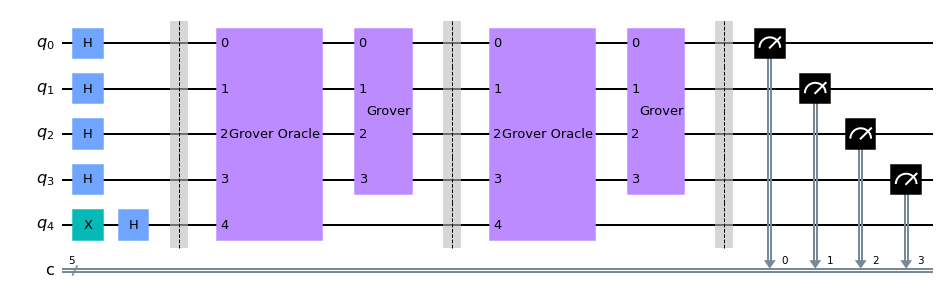

In [13]:
# 2 grover iteration are needed
grover_iterations = 2

for i in range(grover_iterations) :
    # apply grover oracle
    circuit.compose(grover_oracle(), qubits = range(5), inplace = True)

    # apply grover operatior 
    circuit.append(grover_operator(4), range(4))

    circuit.barrier()

# measure the 4 qubits we are interested
circuit.measure(range(4), range(4))

# draw the circuit
%matplotlib inline
circuit.draw('mpl')

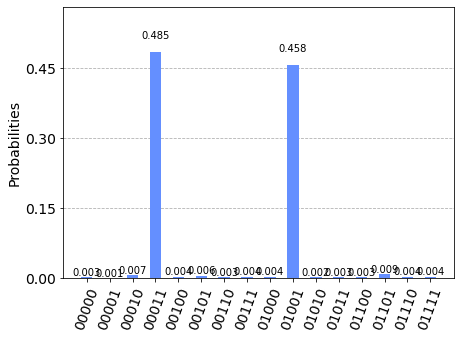

In [14]:
# then we simulate the circuit and see the results
simulator = simulator = Aer.get_backend('qasm_simulator')

# execute the simulation with 1000 shots
result = execute(circuit, backend = simulator, shots = 1000).result()

# get counts and print the histogram
counts = result.get_counts()

plot_histogram(counts)

<pre>
After getting the results from the simulation, we see as expected only two solutions with higher probabilities
the two cases are : X in the main diagonal and x in the middle row
</pre>

$$\ket{1100}, \ket{1001}$$

<pre>
If we were to start one step earlier and the oponent has not yest chosen, by this situation:

X | O | O 
X | ? | ?
? | ? | ?

The new qubit representation will now be:
X | O | O 
X | q0 | q1
q2 | q3 | q4

This means that we may have more winning probabilities which are based on opponents choise (entangled with the opponent choice)
</pre>

In [15]:
# create the new circuit
circuit = QuantumCircuit(6, 6)

# put the 4 qubits we seek for the solution in superposition
circuit.h(range(5))

# put the last qubit in state |-> as previously for the phase kickback
circuit.x(5)
circuit.h(5)

In [16]:
# out new oracle is needed
def grover_oracle2() :
    circuit = QuantumCircuit(6)

    # this winning case is when we have x in the middle row
    circuit.x([2, 3, 4])
    circuit.mct([0, 1, 2, 3, 4], 5)
    circuit.x([2, 3, 4])

    # this winning case is when we have x in the main diagonal
    circuit.x([1, 2, 3])
    circuit.mct([0, 1, 2, 3, 4], 5)
    circuit.x([1, 2, 3])

    # this winning case is when we have x in the 1st column
    # this winning can have 4 different winning states 
    circuit.x([0, 1, 3])
    circuit.mct([0, 1, 2, 3, 4], 5)
    circuit.x([0, 1, 3])

    circuit.x([0, 1, 4])
    circuit.mct([0, 1, 2, 3, 4], 5)
    circuit.x([0, 1, 4])

    circuit.x([0, 3, 4])
    circuit.mct([0, 1, 2, 3, 4], 5)
    circuit.x([0, 3, 4])

    circuit.x([1, 3, 4])
    circuit.mct([0, 1, 2, 3, 4], 5)
    circuit.x([1, 3, 4])
    
    return circuit.to_gate(label = 'Grover Oracle')

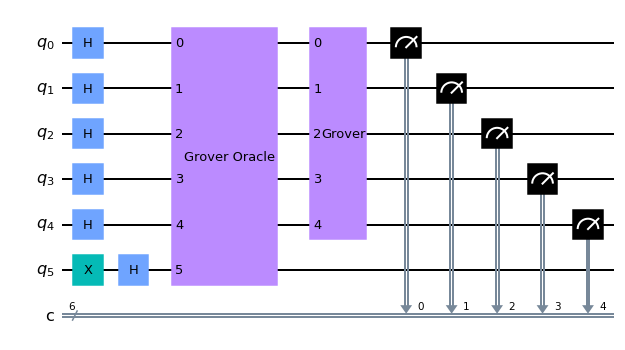

In [17]:
# apply grover oracle, only one iteration is needed in this case
circuit.compose(grover_oracle2(), qubits = range(6), inplace = True)
circuit.append(grover_operator(5), range(5))

# measure the 5 qubits we are interested in 
circuit.measure(range(5), range(5))

%matplotlib inline
circuit.draw('mpl')

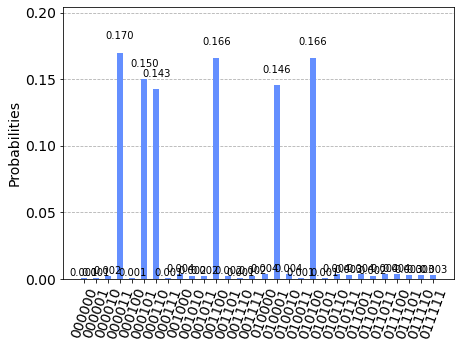

In [18]:
# then we simulate the circuit and see the results
simulator = simulator = Aer.get_backend('qasm_simulator')

# execute the simulation with 1000 shots
result = execute(circuit, backend = simulator, shots = 1000).result()

# get counts and plot histogram
counts = result.get_counts()
plot_histogram(counts)

<pre>
Finally after the quantum search the states that are the winning solution of the game are 6:
</pre>
$$\ket{11000}$$
$$\ket{01100}$$
$$\ket{00110}$$
$$\ket{10001}$$
$$\ket{00101}$$
$$\ket{10100}$$